<a href="https://colab.research.google.com/github/toskpl/Challenge_DW/blob/master/part2/day4/cifar10_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
"""import bibliotek"""
import tensorflow as tf
import os

from tensorflow.python.keras.datasets import cifar10
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.python.keras.utils import to_categorical
import numpy as np
np.random.seed(2018)
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
"""wczytanie zbioru danych cifar10"""
(X_train, y_train), (X_test,y_test) = cifar10.load_data()

#zbior train / test
#50 000 / 10 000zdjęć
#32
#32
#3 kanal zdjecia kolorowe
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

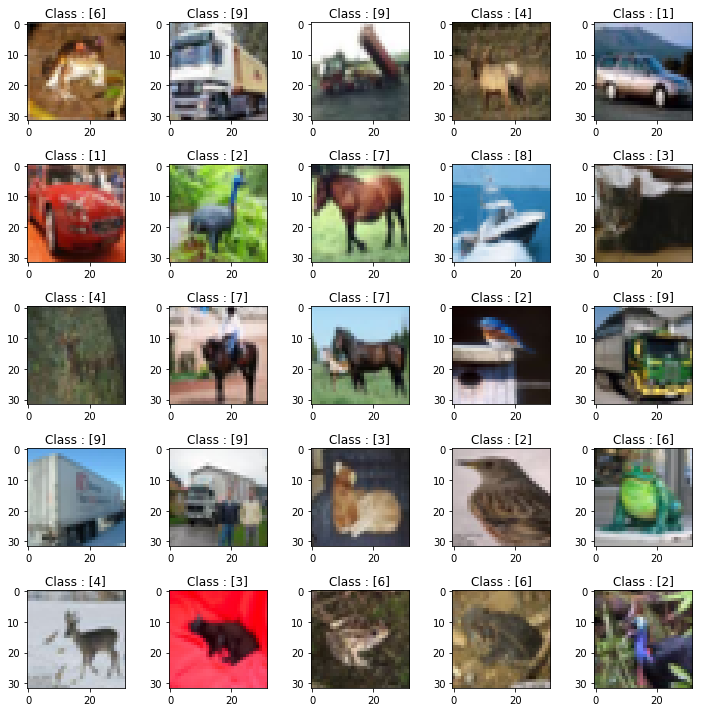

In [0]:
plt.figure(figsize=(10,10))
for idx in range(25):
    plt.subplot(5,5, idx+1)
    plt.imshow(X_train[idx], cmap ='gray')
    plt.title('Class : {}'.format(y_train[idx]))

plt.tight_layout()

In [0]:
img_rows, img_cols = X_train.shape[1],X_train.shape[2]

num_channels = 3 #kanal 3 zdjecia kolorowe RGB
X_train = X_train.reshape(-1,img_rows,img_cols,num_channels)
X_test = X_test.reshape(-1,img_rows,img_cols,num_channels)

#rozmiar input + kanał
input_shape = (img_rows, img_cols,num_channels)

X_train.shape,X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [0]:
#normalizacja
if np.max(X_train)>1: X_train = X_train /255
if np.max(X_test)>1: X_test = X_test /255

In [0]:
#weryfikacja normazlizaji dla: 
# train
# test
X_train.max(),X_train.min(),X_test.max(),X_test.min()

(1.0, 0.0, 1.0, 0.0)

In [0]:
if len(y_train.shape) ==2:
    y_train = y_train.reshape(-1)
    y_test = y_test.reshape(-1)

if len(y_train.shape) ==1:
    num_classes = len(set(y_train))
    y_train = to_categorical(y_train ,num_classes)
    y_test = to_categorical(y_test ,num_classes)

In [0]:
"""weryfikacja rozmiarow"""
#train 50 000 elementów 10 class
#test 10 000 elementow, 10 class
#num_classes 10 class
y_train.shape,y_test.shape,num_classes

((50000, 10), (10000, 10), 10)

In [0]:
""" architektura modelu """
model = Sequential([
    Conv2D(filters = 32, kernel_size= (3,3),input_shape = input_shape),
    Conv2D(filters = 32, kernel_size= (3,3),input_shape = input_shape),
    MaxPool2D(pool_size = (2,2)),
    Dropout(0.25),
    
    Conv2D(filters = 64, kernel_size= (3,3)),
    Conv2D(filters = 64, kernel_size= (3,3)),
    MaxPool2D(pool_size = (2,2)),
    Dropout(0.25),
    
    Conv2D(filters = 128, kernel_size= (3,3)),
    MaxPool2D(pool_size = (2,2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(1024,activation = 'relu'),
    Dropout(0.5),    
    Dense(num_classes,activation = 'softmax')
])


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
__________

In [0]:
""" pobiera adres dla TPU"""
os.environ['COLAB_TPU_ADDR']

'10.59.35.194:8470'

In [0]:
""" grpc protokol """
TPU_WORKER = 'grpc://'+ os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

In [0]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

INFO:tensorflow:Querying Tensorflow master (grpc://10.59.35.194:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 9092507764936177292)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 11383168758331805943)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 2669530982392264743)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 5387343381514611820)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 873532604282130530)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/j

In [0]:
""" kompilacja modelu"""
# optymalizator adam, 
# metryka accuracy, 
# loss = klasyfikacja birnana w keras
tpu_model.compile(loss = 'categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

## Trenowanie


In [0]:

tpu_model.fit(
    X_train,y_train,
    batch_size = 128*8,
    epochs = 20,
    validation_split= 0.2
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(128, 32, 32, 3), dtype=tf.float32, name='conv2d_10_input_20'), TensorSpec(shape=(128, 10), dtype=tf.float32, name='dense_5_target_40')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for conv2d_10_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f26f4111550> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.196682929992676 secs
48128/50000 [===========================>..] - ETA: 0s - loss: 1.2903 - acc: 0.5425INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [

## Wykorzystano TPU szybko sie liczylo kolo 7 sek dla jednej epoki
## Skomplikowano architekturę i uzyto 20 epok val_acc = 0,5406

In [0]:
score = tpu_model.evaluate (X_test,y_test)
score

INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(4,), dtype=tf.int32, name='core_id_20'), TensorSpec(shape=(4, 32, 32, 3), dtype=tf.float32, name='conv2d_10_input_20'), TensorSpec(shape=(4, 10), dtype=tf.float32, name='dense_5_target_40')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_10_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f26f0e2a898> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 3.147733688354492 secs
 9984/10000 [============================>.] - ETA: 0s - loss: 1.5736 - acc: 0.5410INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(2,), dtype=tf.int32, name='core_id_20'), TensorSpec(shape=(2, 32, 32, 3), dtype=tf.float32, name='conv2d_10_input_20'), TensorSpec(shape=(2, 10), dtype=tf.float32, name='dense_5_target_40')]
INFO:tensorflow:Overriding de

[1.5742581245422362, 0.54069996]